In [2]:
from Bio import SeqIO
import pandas as pd
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib_venn import venn3, venn3_circles
import numpy as np

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'sans-serif'

import re
from collections import defaultdict

In [3]:
phylogeny_order = ['Chanos_chanos',
    'Triplophysa_siluroides',
    'Triplophysa_tibetana',
    'Triplophysa_dalaica',
    'Danionella_dracula',
    'Danionella_translucida',
    'Danio_jaintianensis',
    'Danio_choprai',
    'Danio_albolineatus',
    'Danio_aesculapii',
    'Danio_rerio',
    'Danio_kyathit',
    'Danio_tinwini',
    'Leuciscus_waleckii',
    'Gobiocypris_rarus',
    'Paracanthobrama_guichenoti',
    'Ctenopharyngodon_idella',
    'Hypophthalmichthys_molitrix',
    'Anabarilius_grahami',
    'Culter_alburnus',
    'Megalobrama_amblycephala',
    'Labeo_rohita',
    'Labeo_catla',
    'Puntigrus_tetrazona',
    'Oxygymnocypris_stewartii',
    'Onychostoma_macrolepis',
    'Cyprinus_carpio',
    'Carassius_auratus',
    'Sinocyclocheilus_rhinocerous',
    'Sinocyclocheilus_anshuiensis',
    'Sinocyclocheilus_grahami',
    'Sinocyclocheilus_maitianheensis',
    'Sinocyclocheilus_anophthalmus'
]

In [5]:
def count_finz_znf(species):
    count = 0
    with open('../data/seqs/cypriniformes_augustus_finz.fa') as infile:
        for line in infile:
            if line.startswith(f'>{species}'):
                count += 1
    return count

def count_finz_exons(species):
    count = 0
    with open(f'../data/blast-out/{species}_finz_locs.out') as infile:
        for line in infile:
            count += 1
    return count

def count_znf_hits(species):
    count = 0
    with open(f'../data/blast-out/{species}_znf_locs.out') as infile:
        for line in infile:
            count += 1
    return count

count_df = pd.DataFrame({'species': phylogeny_order})
count_df['finz_znf'] = count_df.species.apply(count_finz_znf)
count_df['finz_exons'] = count_df.species.apply(count_finz_exons)
print(count_df)

                            species  finz_znf  finz_exons
0                     Chanos_chanos         0           0
1            Triplophysa_siluroides         0           1
2              Triplophysa_tibetana         0           0
3               Triplophysa_dalaica         0           0
4                Danionella_dracula         4           3
5            Danionella_translucida         9           5
6               Danio_jaintianensis        93         111
7                     Danio_choprai        64          92
8                Danio_albolineatus       334         563
9                  Danio_aesculapii       389         439
10                      Danio_rerio       684         892
11                    Danio_kyathit       593         804
12                    Danio_tinwini        96         150
13               Leuciscus_waleckii       106         196
14                Gobiocypris_rarus       322         490
15       Paracanthobrama_guichenoti       347         500
16          Ct

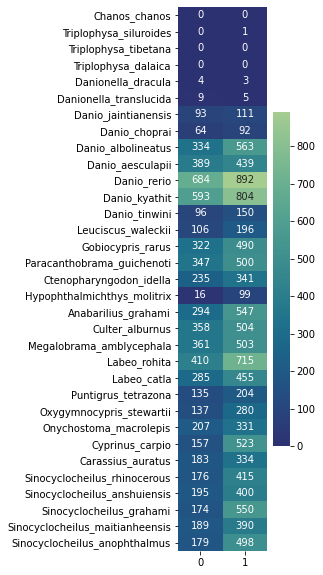

In [45]:
# nfinz = [[0]]
# for sp in phylogeny_order[1:]:
#     nfinz.append(count_df.loc[count_df.species == sp]['finz_znf', 'finz_exons'])

nfinz = [[i[1].finz_znf, i[1].finz_exons] for i in count_df.iterrows()]
fig, ax = plt.subplots(figsize=(2,10))
sns.heatmap(nfinz, cmap='crest_r', annot=True, fmt='d', yticklabels=phylogeny_order, ax=ax)
# plt.savefig('../figs/nfinz_heatmap.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
seqdict = {}
for record in SeqIO.parse('../data/seqs/cypriniformes_augustus_finz.fa', 'fasta'):
    seqdict[record.id] = str(record.seq)

In [14]:
seqlens = [(key, len(val)) for key, val in seqdict.items()]
seq_df = pd.DataFrame(seqlens, columns=['name', 'length'])
seq_df['species'] = seq_df.name.apply(lambda x: '_'.join(x.split('_')[:2]))
print(seq_df.head())

                        name  length              species
0  Danio_jaintianensis_g2.t1     294  Danio_jaintianensis
1  Danio_jaintianensis_g4.t1     418  Danio_jaintianensis
2  Danio_jaintianensis_g5.t1     546  Danio_jaintianensis
3  Danio_jaintianensis_g6.t1     306  Danio_jaintianensis
4  Danio_jaintianensis_g7.t1     482  Danio_jaintianensis


In [15]:
def extract_exons(species, genelist):
    exons = defaultdict(int)
    with open(f'../data/gffs/{species}_augustus_finz.gff') as infile:
        for line in infile:
            if line.startswith('#'):
                continue
            line = line.split()
            if line[2] != 'CDS':
                continue
            parent = re.search('Parent=(.+)$', line[8]).group(1)
            exons[f'{species}_{parent}'] += 1
    return {key: exons[key] for key in genelist}

In [16]:
for species in set(seq_df.species.tolist()):
    genelist = seq_df.loc[seq_df.species == species, 'name'].tolist()
    exons = extract_exons(species, genelist)
    seq_df.loc[seq_df.species == species, 'exons'] = seq_df['name'].apply(exons.get)
print(seq_df.head())

                        name  length              species  exons
0  Danio_jaintianensis_g2.t1     294  Danio_jaintianensis    7.0
1  Danio_jaintianensis_g4.t1     418  Danio_jaintianensis    4.0
2  Danio_jaintianensis_g5.t1     546  Danio_jaintianensis    4.0
3  Danio_jaintianensis_g6.t1     306  Danio_jaintianensis    5.0
4  Danio_jaintianensis_g7.t1     482  Danio_jaintianensis    4.0


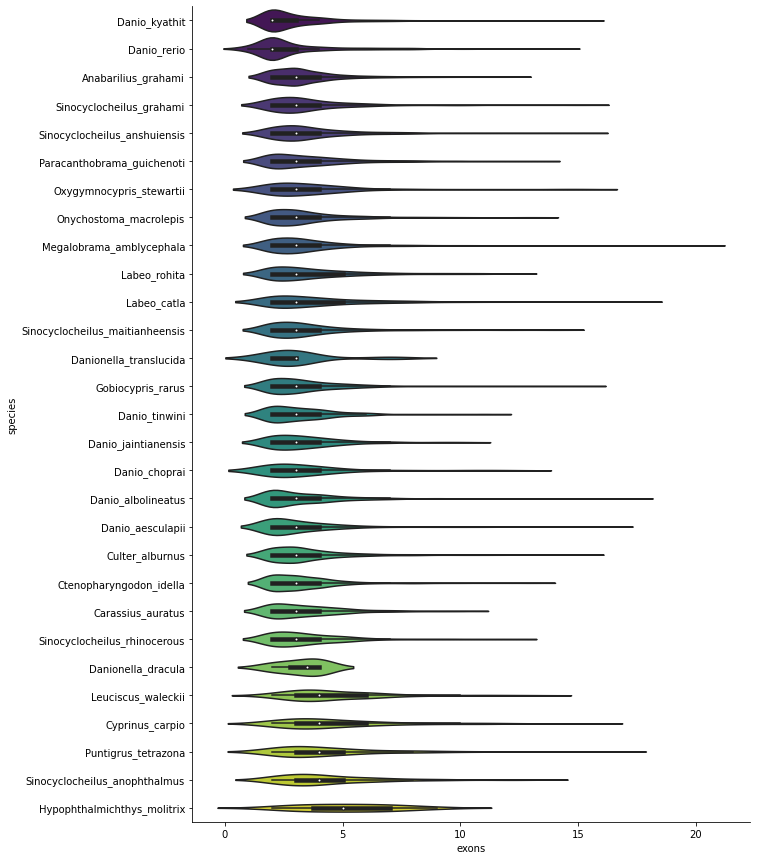

In [17]:
sortorder = seq_df.groupby('species').median().reset_index().sort_values('exons').species.tolist()
fig, ax = plt.subplots(figsize=(10, 15))
sns.violinplot(data=seq_df, x='exons', y='species', order=sortorder, palette='viridis')
sns.despine()
plt.show()